# My First EDA Project

### The data

- The datasets can be found in the respective folders in this repository.
- Each folder contains the dataset either as a .csv or .txt file. The description of
the column names can be found in the column_names.md files.
- The column names may NOT be clear at times:


### Tasks for you

1. Create a new repo and a new virtual environment.
2. Through EDA/statistical analysis above please come up with AT LEAST 3
insights/recommendations for your stakeholder.
If you use linear regression in the exploration phase remember that R2
 close
to 1 is good.
3. Then, model this dataset with a multivariate linear regression to predict
b. For US Bank Wages: The salary (or log(salary)) as accurately as
possible. Note you can take either the perspective of an applicant or
company.
i. Split the dataset into a train and a test set. (use the sklearn split
method
https://scikit-learn.org/stable/modules/generated/sklearn.mod
el_selection.train_test_split.html )
ii. Use Root Mean Squared Error (RMSE) as your metric of success
and try to minimize this score on your test data.

### The Deliverables

1. A well documented Jupyter Notebook (see here for an example) containing
the code you've written for this project and comments explaining it. This work
will need to be pushed to your GitHub repository in order to submit your
project (latest upload: 18.02.2020 12:00). Do not push all the analysis... just
the analysis that is relevant!
2. A Python script for training the model, printing out the model statistics and
saving the model.
3. An organized README.md file in the GitHub repository that describes the
contents of the repository. This file should be the source of information for
navigating through the repository.
4. A short Keynote/PowerPoint/Google Slides/Jupyter slides presentation
giving a high-level overview of your methodology and recommendations for
non-technical stakeholders. The duration of the presentation should be 10
minutes, then the discussion will continue for 5 minutes. Also put your slides
(delivered as a PDF export) on Github to get a well-rounded project

### For the ease of this task I will postulate a story background and an imaginary client:

# The Stakeholder

Is a NGO that works on the integration of female war-refugees into society.

### The Task

- The NGO is suspecting that a certain bank does not follow their own code of conduct.

### The Questions
- What is the salary based on in this bank?
- Is there an difference in pay between male and female employees?
- Would females with a minority background have the same chances for a fair salary as non-minority women?


# Setup Python

In [237]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.graphics.regressionplots import plot_partregress_grid

from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.iolib.smpickle import load_pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Load Data

### I am loading the data set and look at its basic structure and statics metrics.

In [270]:
# loading project data
data = pd.read_csv('us_bank_wages/us_bank_wages.txt', delimiter='\t')
data.to_csv('us_bank_wages/us_bank_wages_data.csv')

In [271]:
# print descritive information of loaded data set
data.shape
data.head(3)

(474, 7)

,Unnamed: 0,SALARY,EDUC,SALBEGIN,GENDER,MINORITY,JOBCAT
0,0,57000,15,27000,1,0,3
1,1,40200,16,18750,1,0,1
2,2,21450,12,12000,0,0,1


In [272]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  474 non-null    int64
 1   SALARY      474 non-null    int64
 2   EDUC        474 non-null    int64
 3   SALBEGIN    474 non-null    int64
 4   GENDER      474 non-null    int64
 5   MINORITY    474 non-null    int64
 6   JOBCAT      474 non-null    int64
dtypes: int64(7)
memory usage: 26.0 KB


,Unnamed: 0,SALARY,EDUC,SALBEGIN,GENDER,MINORITY,JOBCAT
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000
mean,236.500000,34419.567511,13.491561,17016.086498,0.544304,0.219409,1.411392
std,136.976275,17075.661465,2.884846,7870.638154,0.498559,0.414284,0.773201
min,0.000000,15750.000000,8.000000,9000.000000,0.000000,0.000000,1.000000
25%,118.250000,24000.000000,12.000000,12487.500000,0.000000,0.000000,1.000000
50%,236.500000,28875.000000,12.000000,15000.000000,1.000000,0.000000,1.000000
75%,354.750000,36937.500000,15.000000,17490.000000,1.000000,0.000000,1.000000
max,473.000000,135000.000000,21.000000,79980.000000,1.000000,1.000000,3.000000


# Data Cleaning

### For the cleaning of the data, I will add some columns and check for Nans.

In [246]:
# checking for NaN 
data.isnull().sum()
data.isnull().values.any()

list(data.columns)
data.drop('Unnamed: 0', axis=1, inplace=True)

# to drop all NaN values
#data.dropna(inplace=True)
# eaxmple to fill NaN
#data['SALBEGIN'].fillna(df['SALBEGIN'].mean(), inplace=True)

# de-skewing - explaination: the SALERY colmuns are right skewed and to compensate for that I use log() 
data.eval('LSALARY = log(SALARY)', inplace = True)
data.eval('LSALBEGIN = log(SALBEGIN)', inplace = True)

Unnamed: 0    0
SALARY        0
EDUC          0
SALBEGIN      0
GENDER        0
MINORITY      0
JOBCAT        0
dtype: int64

False

['Unnamed: 0', 'SALARY', 'EDUC', 'SALBEGIN', 'GENDER', 'MINORITY', 'JOBCAT']

# Data Prep

### During preparation of the data, I will split into train and test data. I will also create a version of the data where I add more readable categorical values, for ease of interpretation and better readability.

In [273]:
# make work copy of data

work = data.copy();

In [274]:
# inside the work copy the coded values are converted to categorical values - for better readability 

'''
GENDER: gender variable (0 for females, 1 for males)
MINORITY: minority variable (0 for non-minorities, 1 for minorities)
JOBCAT: job category (1 for administrative jobs, 2 for custodial jobs, 3 for management jobs)
EDUCT: [8, 12, 14, 15, 16, 17, 18, 19, 20, 21] - list(train.EDUC.sort_values().unique())list(train.EDUC.sort_values().unique())
'''

def map_educ(x):
    if x == 8: return 'primary'
    elif x == 12: return 'secondary'
    elif x > 12: return 'university'
work['EDUC'] = work.EDUC.apply(map_educ).astype('category')

map_dict = {0: 'female', 1:'male'}
work['GENDER'] = work['GENDER'].map(map_dict)
map_dict = {0: 'non-minorities', 1:'minorities'}
work['MINORITY'] = work['MINORITY'].map(map_dict)
map_dict = {1: 'administrative', 2:'custodial', 3:'management'}
work['JOBCAT'] = work['JOBCAT'].map(map_dict)

'\nGENDER: gender variable (0 for females, 1 for males)\nMINORITY: minority variable (0 for non-minorities, 1 for minorities)\nJOBCAT: job category (1 for administrative jobs, 2 for custodial jobs, 3 for management jobs)\nEDUCT: [8, 12, 14, 15, 16, 17, 18, 19, 20, 21] - list(train.EDUC.sort_values().unique())list(train.EDUC.sort_values().unique())\n'

In [249]:
work.head(3)

,SALARY,EDUC,SALBEGIN,GENDER,MINORITY,JOBCAT,LSALARY,LSALBEGIN
0,57000,university,27000,male,non-minorities,management,10.950807,10.203592
1,40200,university,18750,male,non-minorities,administrative,10.601622,9.838949
2,21450,secondary,12000,female,non-minorities,administrative,9.973480,9.392662


In [250]:
# spliting data into train and test data

train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True) # random_state = seed !!

train.shape, test.shape

((379, 8), (95, 8))

# EDA Start

### The EDA is a cycle and I went through it multiples times. Each time I improved my plots and my analysis of the data. What you see below, is the accumulated result.

### Column Names and descriptions for US Bank Wages data set
* **SALARY**:  current yearly salary in dollar [\$]
* **EDUC**: education (number of finished years)
* **SALBEGIN**: yearly salary at employee's first position at same bank in dollars [\$]
* **GENDER**: gender variable (0 for females, 1 for males)
* **MINORITY**: minority variable (0 for non-minorities, 1 for minorities)
* **JOBCAT**: - job category (1 for administrative jobs, 2 for custodial jobs, 3 for management jobs)

In [251]:
InteractiveShell.ast_node_interactivity = "all"

First, I am looking for general correlations as well as more specific ones.

For example the distribution of certain group, like female and male a.o. inside the data.

The goal is to obtain indications if we may have data that is not relevant for our analysis. And vise versa identify influential features.

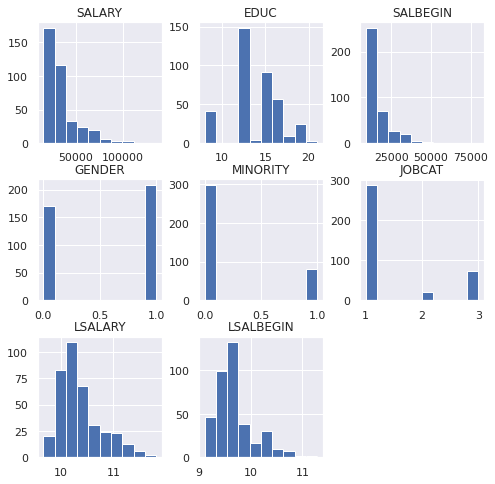

In [217]:
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
train.hist(ax = ax);

In [252]:
work.groupby('JOBCAT').size()

JOBCAT
administrative    363
custodial          27
management         84
dtype: int64

In [253]:
work.groupby('GENDER').size()

GENDER
female    216
male      258
dtype: int64

In [254]:
work.groupby('MINORITY').size()

MINORITY
minorities        104
non-minorities    370
dtype: int64

104 / (370+104) = 0.219 - ratio of minorities is ~= 22%

216 / (258+216) = 0.455 - ratio of female is ~= 46%

In [234]:
chartA = alt.Chart(work).mark_bar().encode(
    x='SALARY',
    y='MINORITY',
    color='JOBCAT')

chartB = alt.Chart(work).mark_bar().encode(
    x='SALARY',
    y='GENDER',
    color='JOBCAT')

chart1 = alt.Chart(work).mark_bar().encode(
    x='SALARY',
    y='JOBCAT',
    color='MINORITY')

chart2 = alt.Chart(work).mark_bar().encode(
    x='SALARY',
    y='JOBCAT',
    color='GENDER')

chart3 = alt.Chart(work).mark_bar().encode(
    x='SALARY',
    y='MINORITY',
    color='GENDER')

chart4 = alt.Chart(work).mark_bar().encode(
    x='GENDER',
    y='JOBCAT',
    color='EDUC')

chart5 = alt.Chart(work).mark_bar().encode(
    x='EDUC',
    y='JOBCAT',
    color='MINORITY')

chart6 = alt.Chart(work).mark_bar().encode(
    x='EDUC',
    y='JOBCAT',
    color='GENDER')

chartA
chartB
chart1
chart2
chart3
chart4 | chart5 | chart6

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.HConcatChart(...)

In [133]:
pd.crosstab([work.GENDER,work.MINORITY], [work.EDUC,work.JOBCAT], margins=True, margins_name="Total")

EDUC                         primary                secondary            \
JOBCAT                administrative custodial administrative custodial   
GENDER MINORITY                                                           
female minorities                  3         0             27         0   
       non-minorities             27         0            101         0   
male   minorities                  4         7             18         5   
       non-minorities              6         6             30         8   
Total                             40        13            176        13   

EDUC                                 university                      Total  
JOBCAT                management administrative custodial management        
GENDER MINORITY                                                             
female minorities              0             10         0          0    40  
       non-minorities          0             38         0         10   176  
male   minorities              1             25         1          3    64  
       non-minorities          0             74         0         70   194  
Total                          1            147         1         83   474

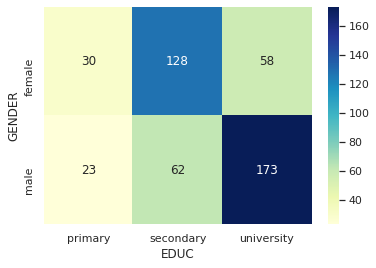

In [134]:
sns.heatmap(pd.crosstab([work.GENDER], [work.EDUC]),
            cmap="YlGnBu", annot=True, cbar=True, fmt='g');

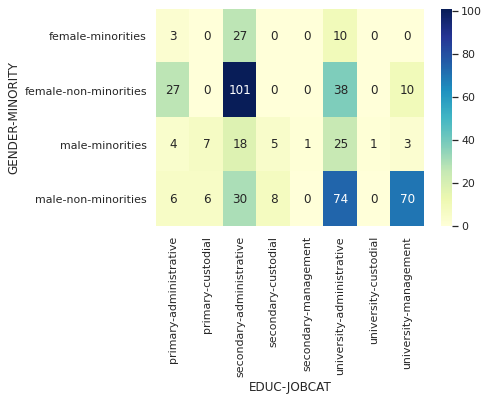

In [135]:
sns.heatmap(pd.crosstab([work.GENDER,work.MINORITY], [work.EDUC,work.JOBCAT]),
            cmap="YlGnBu", annot=True, cbar=True, fmt='g');

In [136]:
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

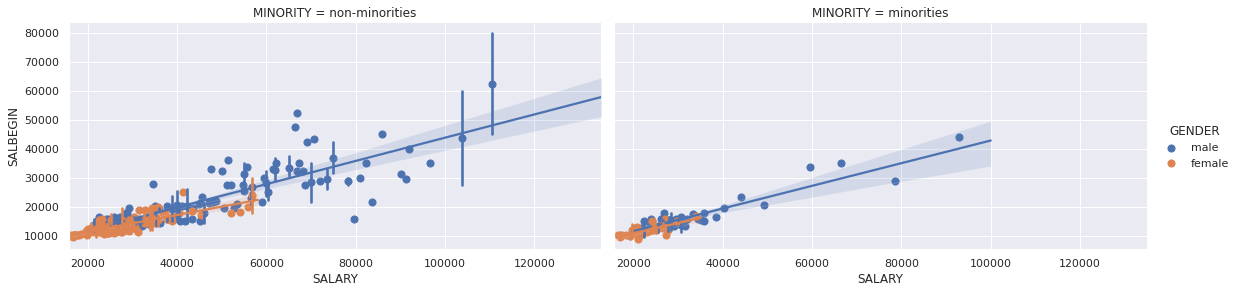

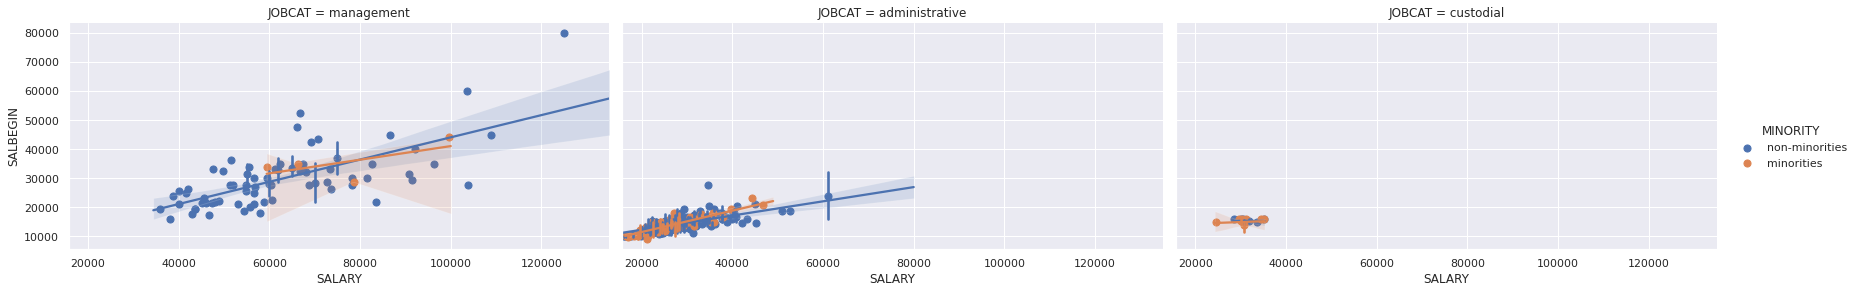

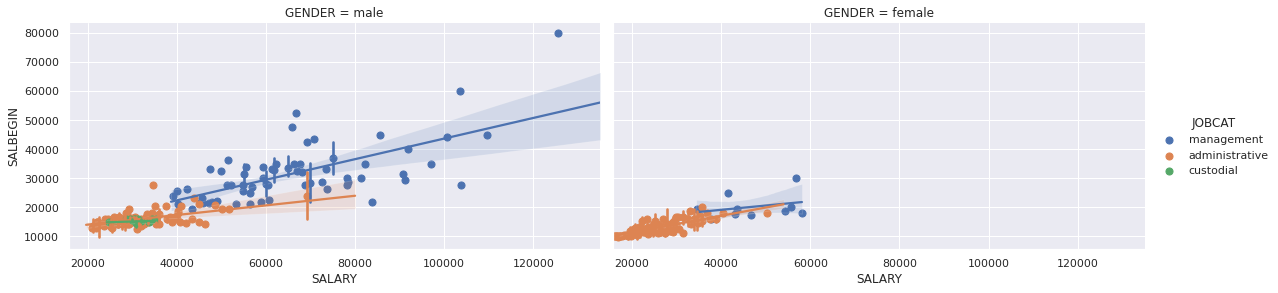

In [147]:
sns.set_theme(color_codes=True)
sns.lmplot(x="SALARY", y="SALBEGIN", hue="GENDER", col="MINORITY", data=work, x_bins=int(len(list(train_Y))/2), height=4, aspect=2);
sns.lmplot(x="SALARY", y="SALBEGIN", hue="MINORITY", col="JOBCAT", data=work, x_bins=int(len(list(train_Y))/2), height=4, aspect=2);
sns.lmplot(x="SALARY", y="SALBEGIN", hue="JOBCAT", col="GENDER", data=work, x_bins=int(len(list(train_Y))/2), height=4, aspect=2);

### Result: I can see influences of features like EDUC (education) and I also can see that gender and group affiliation has an impact on the salary of an employee.

# Model Creation

### Now, I am looking for a Linear Regression Model based on the formula: $Y_i = \beta_0 + \beta_1 X_i + \epsilon_i$

### The goal is to predict a target based on a set of features.

### First I am analyzing feature scatter-plots and feature correlations.

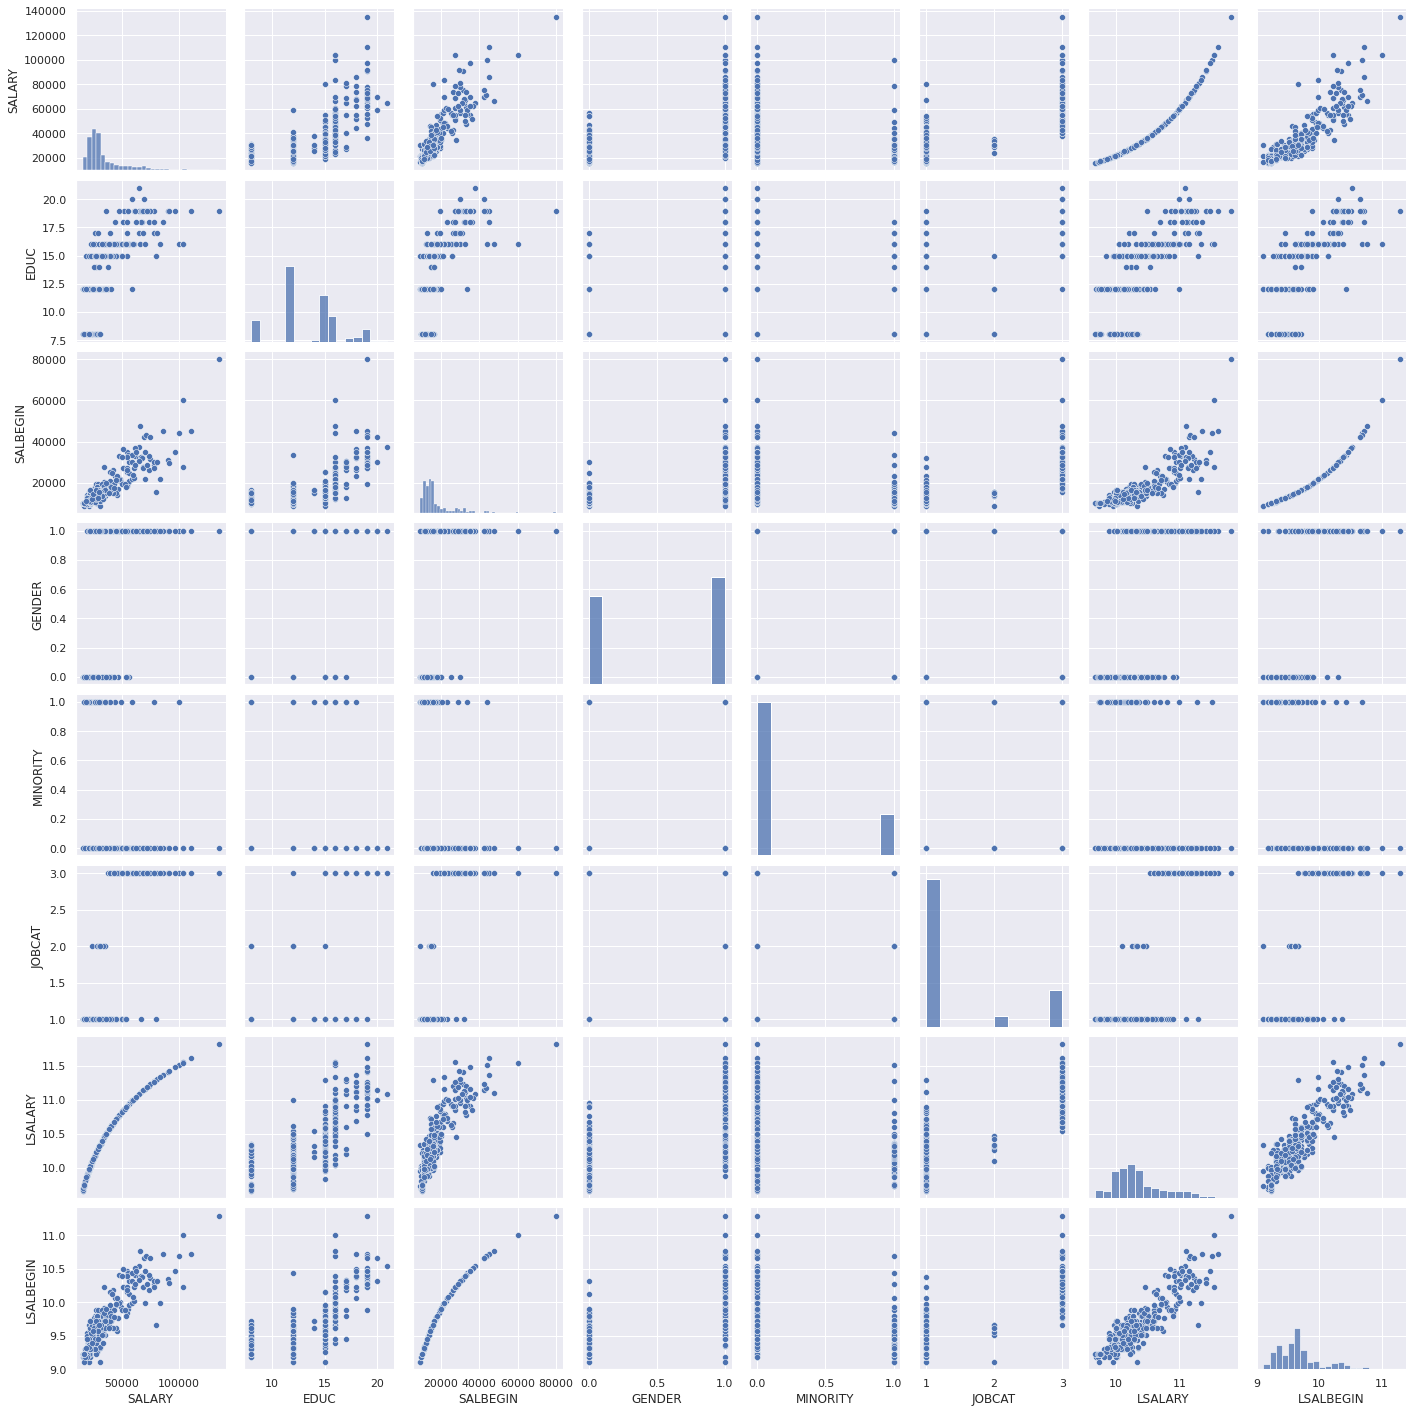

In [113]:
sns.pairplot(train);

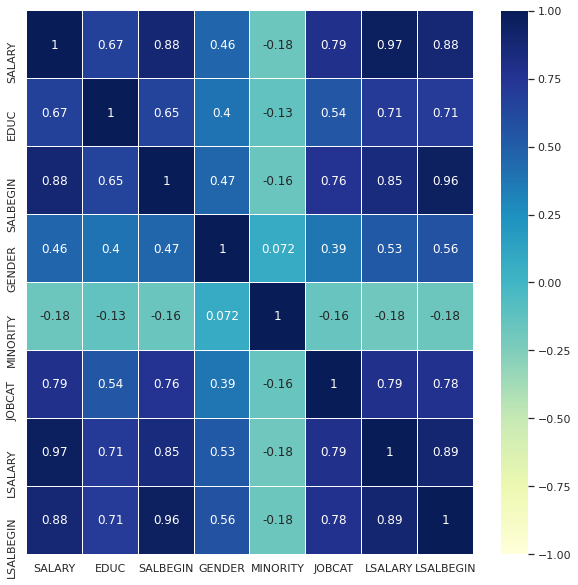

In [137]:
df_kor = train.corr()
plt.figure(figsize=(10,10))
sns.heatmap(df_kor, vmin=-1, vmax=1, cmap="YlGnBu", annot=True, linewidth=0.1); 

In [25]:
# EDA by single column

cols = train.columns.to_list()
cols.remove('SALARY')
cols
for col in cols:
    print(col)
    print('\t    rsquared:',smf.ols(formula=f'SALARY ~ '+col, data=train).fit().rsquared)
    print('\trsquared_adj:',smf.ols(formula=f'SALARY ~ '+col, data=train).fit().rsquared_adj)
    print('\t    f_pvalue:',smf.ols(formula=f'SALARY ~ '+col, data=train).fit().f_pvalue)

EDUC
	    rsquared: 0.4492348651516894
	rsquared_adj: 0.44777394967463824
	    f_pvalue: 9.078725684143804e-51
SALBEGIN
	    rsquared: 0.7812131394829096
	rsquared_adj: 0.7806328029828643
	    f_pvalue: 1.8229693004773198e-126
GENDER
	    rsquared: 0.2109923305655248
	rsquared_adj: 0.20889947202591086
	    f_pvalue: 3.523498859191208e-21
MINORITY
	    rsquared: 0.0314140275695004
	rsquared_adj: 0.02884483400867688
	    f_pvalue: 0.000527120608253628
JOBCAT
	    rsquared: 0.6186414418746766
	rsquared_adj: 0.6176298807125404
	    f_pvalue: 6.286696641267465e-81


### Result: It seems that SALBEGIN has a high influence on SALARY 

# Linear Regression

### I am using the OLS method form Pythons **statsmodels** modul to compute: $Y_i = \beta_0 + \beta_1 X_i$

In [255]:
# I am checking the time-cost for model computation

f = 'SALARY ~ SALBEGIN + GENDER + C(MINORITY) + C(JOBCAT) + C(EDUC)'
smf.ols(formula=f, data=train).fit().rsquared_adj
%timeit smf.ols(formula=f, data=train).fit().rsquared_adj

0.8264595455648863

8.88 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### As the computation does not take long, I chose a brute-force approach for best model fit.

### I define a function to call the **osl()** multiple times and add an option to use **log()** salary.

In [257]:
# define function for brute-force computation of all models
def find_best_model(var,log=False):
    r = {}
    for t in var:
        if log:
            f = 'LSALARY ~ ' + ' + '.join(t)
        else:
            f = 'SALARY ~ ' + ' + '.join(t)
        m = smf.ols(formula=f, data=train).fit()
        r[m.rsquared_adj] = f # m.rsquared, m.f_pvalue, np.sqrt(m.mse_resid)
    return r

### I generate a **list()** that contains all possible features combinations.

In [258]:
# generate column combinations - to check various models

var = []
columns = ['SALBEGIN','LSALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)']
for i in range(len(columns)):
    # remove first
    cols = columns[i+1:]
    # add first to end
    cols += columns[:i+1]
    #print(cols)
    
    for i in range(len(cols)):
        if not [cols[i]] in var:
            var.append([cols[i]])
            
        c = cols.copy()
        c.remove(cols[i])
        while len(c):
            if not sorted([x for x in c]) in var:
                var.append(sorted([x for x in c]))
            x = c.pop() # x is only used to have less print-output in JL
            
sorted(var)

[['C(EDUC)'],
 ['C(EDUC)', 'C(JOBCAT)'],
 ['C(EDUC)', 'C(JOBCAT)', 'C(MINORITY)'],
 ['C(EDUC)', 'C(JOBCAT)', 'C(MINORITY)', 'GENDER'],
 ['C(EDUC)', 'C(JOBCAT)', 'C(MINORITY)', 'GENDER', 'LSALBEGIN'],
 ['C(EDUC)', 'C(JOBCAT)', 'C(MINORITY)', 'GENDER', 'SALBEGIN'],
 ['C(EDUC)', 'C(JOBCAT)', 'C(MINORITY)', 'LSALBEGIN'],
 ['C(EDUC)', 'C(JOBCAT)', 'C(MINORITY)', 'LSALBEGIN', 'SALBEGIN'],
 ['C(EDUC)', 'C(JOBCAT)', 'C(MINORITY)', 'SALBEGIN'],
 ['C(EDUC)', 'C(JOBCAT)', 'GENDER'],
 ['C(EDUC)', 'C(JOBCAT)', 'GENDER', 'LSALBEGIN'],
 ['C(EDUC)', 'C(JOBCAT)', 'GENDER', 'LSALBEGIN', 'SALBEGIN'],
 ['C(EDUC)', 'C(JOBCAT)', 'GENDER', 'SALBEGIN'],
 ['C(EDUC)', 'C(JOBCAT)', 'LSALBEGIN'],
 ['C(EDUC)', 'C(JOBCAT)', 'LSALBEGIN', 'SALBEGIN'],
 ['C(EDUC)', 'C(JOBCAT)', 'SALBEGIN'],
 ['C(EDUC)', 'C(MINORITY)'],
 ['C(EDUC)', 'C(MINORITY)', 'GENDER'],
 ['C(EDUC)', 'C(MINORITY)', 'GENDER', 'LSALBEGIN'],
 ['C(EDUC)', 'C(MINORITY)', 'GENDER', 'LSALBEGIN', 'SALBEGIN'],
 ['C(EDUC)', 'C(MINORITY)', 'GENDER', 'SALBEGIN

### Then I am computing **osl()** (LRM) model solutions for all features combinations. Here I am using the **log()** option for salary. 

In [275]:
# run brute force model computation
model_fit_result = find_best_model(var,True)

# list model fittings - top 10
model_fit_result_list = sorted(model_fit_result.keys())[-11:]
for fit in model_fit_result_list:
    print('rsquared_adj:', fit, '\t<-', model_fit_result[fit])

rsquared_adj: 0.8212463008152744 	<- LSALARY ~ C(JOBCAT) + GENDER + LSALBEGIN
rsquared_adj: 0.8215562041400273 	<- LSALARY ~ C(JOBCAT) + C(MINORITY) + GENDER + LSALBEGIN
rsquared_adj: 0.822147741049974 	<- LSALARY ~ C(JOBCAT) + GENDER + LSALBEGIN + SALBEGIN
rsquared_adj: 0.8222770361924634 	<- LSALARY ~ C(JOBCAT) + C(MINORITY) + GENDER + LSALBEGIN + SALBEGIN
rsquared_adj: 0.8316289021838854 	<- LSALARY ~ C(EDUC) + C(JOBCAT) + LSALBEGIN + SALBEGIN
rsquared_adj: 0.8318359486885958 	<- LSALARY ~ C(EDUC) + C(JOBCAT) + LSALBEGIN
rsquared_adj: 0.8319192704737268 	<- LSALARY ~ C(EDUC) + C(JOBCAT) + C(MINORITY) + LSALBEGIN + SALBEGIN
rsquared_adj: 0.8321839207054844 	<- LSALARY ~ C(EDUC) + C(JOBCAT) + C(MINORITY) + LSALBEGIN
rsquared_adj: 0.8322837473882527 	<- LSALARY ~ C(EDUC) + C(JOBCAT) + GENDER + LSALBEGIN + SALBEGIN
rsquared_adj: 0.8326957821614149 	<- LSALARY ~ C(EDUC) + C(JOBCAT) + GENDER + LSALBEGIN
rsquared_adj: 0.8334598691950941 	<- LSALARY ~ C(EDUC) + C(JOBCAT) + C(MINORITY) + GEN

### Then I am computing **osl()** (LRM) model solutions for all features combinations again, but I am **not** using the **log()** option for salary. 

In [260]:
# run brute force model computation
model_fit_result = find_best_model(var,False)

# list model fittings - top 10
model_fit_result_list = sorted(model_fit_result.keys())[-11:]
for fit in model_fit_result_list:
    print('rsquared_adj:', fit, '\t<-', model_fit_result[fit])

rsquared_adj: 0.8182763850083632 	<- SALARY ~ C(JOBCAT) + LSALBEGIN + SALBEGIN
rsquared_adj: 0.8187965885289206 	<- SALARY ~ C(JOBCAT) + C(MINORITY) + GENDER + SALBEGIN
rsquared_adj: 0.8190180154354085 	<- SALARY ~ C(JOBCAT) + C(MINORITY) + GENDER + LSALBEGIN + SALBEGIN
rsquared_adj: 0.8191689261595675 	<- SALARY ~ C(JOBCAT) + GENDER + LSALBEGIN + SALBEGIN
rsquared_adj: 0.8251541213776562 	<- SALARY ~ C(EDUC) + C(JOBCAT) + C(MINORITY) + LSALBEGIN + SALBEGIN
rsquared_adj: 0.8252442092330109 	<- SALARY ~ C(EDUC) + C(JOBCAT) + LSALBEGIN + SALBEGIN
rsquared_adj: 0.8255631713443903 	<- SALARY ~ C(EDUC) + C(JOBCAT) + C(MINORITY) + SALBEGIN
rsquared_adj: 0.8256204234943031 	<- SALARY ~ C(EDUC) + C(JOBCAT) + SALBEGIN
rsquared_adj: 0.8258417789266599 	<- SALARY ~ C(EDUC) + C(JOBCAT) + GENDER + LSALBEGIN + SALBEGIN
rsquared_adj: 0.8262946570863963 	<- SALARY ~ C(EDUC) + C(JOBCAT) + GENDER + SALBEGIN
rsquared_adj: 0.8264595455648863 	<- SALARY ~ C(EDUC) + C(JOBCAT) + C(MINORITY) + GENDER + SALBEG

### I am choosing a feature selection that seems suitable for the target prediction. For reasons of units and ease, I am only using **non-log()** combination for now.

In [261]:
# choosing: the 2nd best, because is has one coef. less 
#   reason: there seems to be some influence of the GENDER but it appears to be quite small (per thousand range)
# rsquared_adj: 0.8256204234943031 	<- SALARY ~ C(EDUC) + C(JOBCAT) + SALBEGIN
# rsquared_adj: 0.8262946570863963 	<- SALARY ~ C(EDUC) + C(JOBCAT) + GENDER + SALBEGIN

f1 = 'SALARY ~ C(EDUC) + C(JOBCAT) + SALBEGIN'   # 0.8256
f2 = 'LSALARY ~ C(EDUC) + C(JOBCAT) + LSALBEGIN' # 0.8318

# !!! f1 - for now !!!

train_model = smf.ols(formula=f1, data=train)
train_model_fit = train_model.fit()

train_model_fit.params

Intercept          6628.670206
C(EDUC)[T.12]      1643.783204
C(EDUC)[T.14]      3633.815913
C(EDUC)[T.15]      4707.838260
C(EDUC)[T.16]      6615.923640
C(EDUC)[T.17]     10941.830944
C(EDUC)[T.18]      8430.570609
C(EDUC)[T.19]     10289.739317
C(EDUC)[T.20]       -10.270960
C(EDUC)[T.21]      -937.772070
C(JOBCAT)[T.2]     3966.086703
C(JOBCAT)[T.3]    11243.592625
SALBEGIN              1.281747
dtype: float64

### Above we see the computed coefficients for the Linear Regression formula:   $\hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_i$

### I am plotting the model solution to get a feeling for the quality of the target prediction.

No handles with labels found to put in legend.


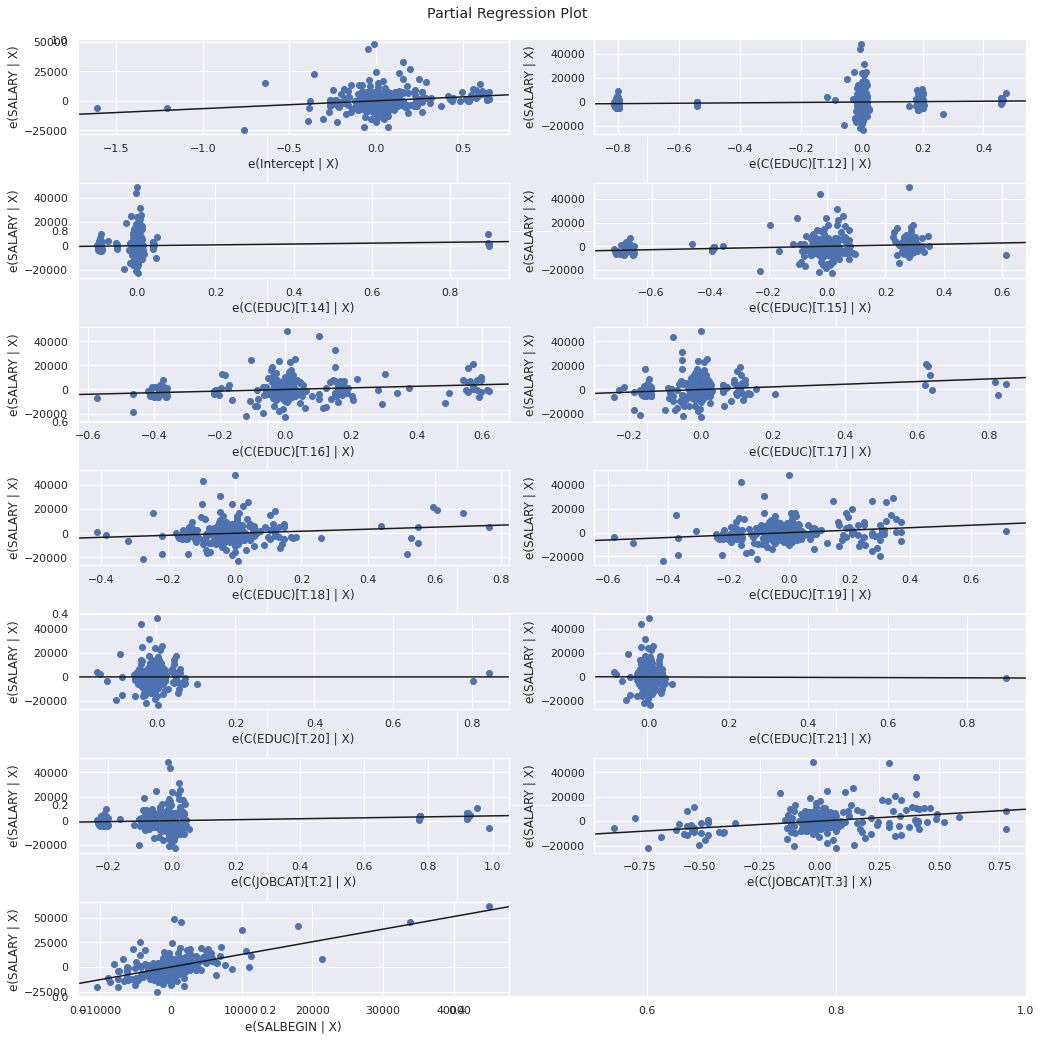

In [152]:
fig, ax = plt.subplots(figsize=(15,15))
plot_partregress_grid(train_model_fit, fig=fig)
ax.legend(loc='best');

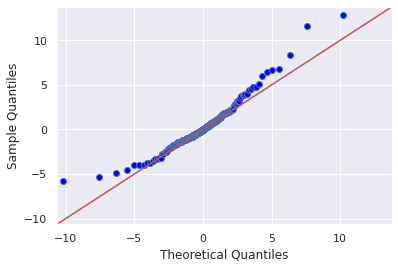

In [150]:
res = train_model_fit.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line="45")
plt.show()

# Model Testing

### First I will computed and plot the targets, using the **train data set**.

In [280]:
train_model_predict = train_model_fit.predict(train);

In [281]:
train_model_actual = train['SALARY'].astype(float);

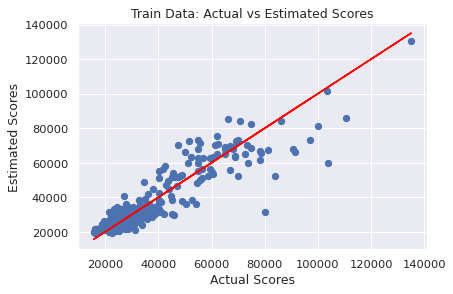

In [282]:
plt.figure(dpi = 75);
plt.scatter(train_model_actual, train_model_predict);
plt.plot(train_model_actual, train_model_actual, color="red");
plt.xlabel("Actual Scores");
plt.ylabel("Estimated Scores");
plt.title("Train Data: Actual vs Estimated Scores");
plt.show();

### Then I will compute the RMSE and other solution quantifiers, using the **train data set**.

In [278]:
print("Mean Absolute Error (MAE)         : {}".format(mean_absolute_error(train_model_actual, train_model_predict)))
print("Mean Squared Error (MSE)          : {}".format(mse(train_model_actual, train_model_predict)))
print("Root Mean Squared Error (RMSE)    : {}".format(rmse(train_model_actual, train_model_predict)))
print("Mean Absolute Perc. Error (MAPE)  : {}".format(np.mean(np.abs((train_model_actual - train_model_predict) / train_model_actual)) * 100))

Mean Absolute Error (MAE)         : 4762.818258860782
Mean Squared Error (MSE)          : 53924465.39180361
Root Mean Squared Error (RMSE)    : 7343.3279507185025
Mean Absolute Perc. Error (MAPE)  : 13.143136437260466


# Test Data

### Next I will computed and plot the targets, using the **test data set**.

In [283]:
train_model_predict = train_model_fit.predict(test);

In [284]:
train_model_actual = test['SALARY'].astype(float);

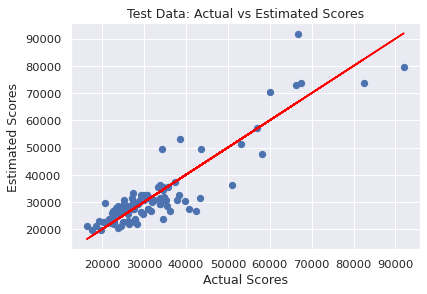

In [285]:
plt.figure(dpi = 75);
plt.scatter(train_model_actual, train_model_predict);
plt.plot(train_model_actual, train_model_actual, color="red");
plt.xlabel("Actual Scores");
plt.ylabel("Estimated Scores");
plt.title("Test Data: Actual vs Estimated Scores");
plt.show();

### And I will compute the RMSE and other solution quantifiers, using the **test data set**.

In [182]:
print("Mean Absolute Error (MAE)         : {}".format(mean_absolute_error(train_model_actual, train_model_predict)))
print("Mean Squared Error (MSE)          : {}".format(mse(train_model_actual, train_model_predict)))
print("Root Mean Squared Error (RMSE)    : {}".format(rmse(train_model_actual, train_model_predict)))
print("Mean Absolute Perc. Error (MAPE)  : {}".format(np.mean(np.abs((train_model_actual - train_model_predict) / train_model_actual)) * 100))

Mean Absolute Error (MAE)         : 4444.375240887274
Mean Squared Error (MSE)          : 38187929.02952326
Root Mean Squared Error (RMSE)    : 6179.638260410011
Mean Absolute Perc. Error (MAPE)  : 13.067452969079248


# Storing Data

### Before I conclude my EDA and model generation, I will deal with data storage.

### Save Model

In [286]:
train_model_fit.save('us_bank_wages/us_bank_wages_train_model_fit.pickle')
train.to_csv('us_bank_wages/us_bank_wages_train.csv')
test.to_csv('us_bank_wages/us_bank_wages_test.csv')

### Read Model

In [287]:
train_model_fit = load_pickle("us_bank_wages/us_bank_wages_train_model_fit.pickle");

In [288]:
train_model_fit.params

Intercept          6628.670206
C(EDUC)[T.12]      1643.783204
C(EDUC)[T.14]      3633.815913
C(EDUC)[T.15]      4707.838260
C(EDUC)[T.16]      6615.923640
C(EDUC)[T.17]     10941.830944
C(EDUC)[T.18]      8430.570609
C(EDUC)[T.19]     10289.739317
C(EDUC)[T.20]       -10.270960
C(EDUC)[T.21]      -937.772070
C(JOBCAT)[T.2]     3966.086703
C(JOBCAT)[T.3]    11243.592625
SALBEGIN              1.281747
dtype: float64

# Warp Up ....

### The Stockholder

Is a NGO that works on the integration of female war-refugees into society.

### The Task

- The NGO is suspecting that a certain bank does not follow their own code of conduct.

### The Questions
- What is the salary based on in this bank?
- Is there an difference in pay between male and female employees?
- Would females with a minority background have the same chances for a fair salery as non-minority women?

# Conclusion



What is the salary based on, in this bank?

- The salary at this bank, is closely correlated to the education and to the type of job.
- There is a also correlation between the salary and the gender as well as the group affiliation of a person.
- Most management position are occupied by male individuals with a non-minority background and an university degree.
- Most of the women are working in administrative positions, where we also find a lower minority quota.
- It could be generalized that the salary is determinant by: Group affiliation, gender and education - is this order.

Is there an difference in pay between male and female employees?

- Yes, it was found that the best paid positions are in management, where the quota for females and minorities is very low.
- There is also a group of badly paid males. They occupy custodial jobs, with a high quota of minorities and no women.
- It could be generalized that women get paid less then the man and that minorities get paid less as well.

Would females with a minority background have the same chances for a fair salary as non-minority women?

- No, the possibilities is lower for women to have the same pay as there male colleagues.
- If the female is part of a minority group, the chances for equal pay would become even lower.
